#### demo: training a DND LSTM on a contextual choice task

This is an implementation of the following paper: 
```
Ritter, S., Wang, J. X., Kurth-Nelson, Z., Jayakumar, S. M., Blundell, C., Pascanu, R., & Botvinick, M. (2018).  
Been There, Done That: Meta-Learning with Episodic Recall. arXiv [stat.ML].  
Retrieved from http://arxiv.org/abs/1805.09692
```

In [1]:
'''
If you are using google colab, uncomment and run the following lines!  
which grabs the dependencies from github
'''
# !git clone https://github.com/qihongl/dnd-lstm.git

# !cd dnd-lstm/src/
# import os
# os.chdir('dnd-lstm/src/')

'\nIf you are using google colab, uncomment and run the following lines!  \nwhich grabs the dependencies from github\n'

In [2]:
import time
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from compositional_metarl.task import MultiArmedBandit
from compositional_metarl.model import QDNDLSTM as Agent
from compositional_metarl.utils import compute_stats, to_sqnp
from compositional_metarl.model.DND import compute_similarities
from compositional_metarl.model.utils import get_reward, compute_returns, compute_a2c_loss, get_reward_mab, run_agent_inference, one_hot_embedding
import matplotlib as mpl
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import torch.nn.functional as F
from compositional_metarl.trainers import Trainer


sns.set(style='white', context='talk', palette='colorblind')
seed_val = 0 # 100 # 0 works for 64
torch.manual_seed(seed_val)
np.random.seed(seed_val)
torch.cuda.manual_seed(seed_val)

In [3]:
'''init task'''

start_arm = 0
end_arm = 7
ctx_dim = 2
n_arms = (end_arm - start_arm) + 1
n_rounds = 20
n_trials = 10
normalize_rewards = True
CUES =  {'linear': torch.tensor([1.0, 0.0]), 'periodic': torch.tensor([0.0, 1.0])}#, 'linperiodic': torch.tensor([1.0, 1.0])} 
task = MultiArmedBandit(cues=CUES, start_arm=start_arm, end_arm=end_arm, ctx_dim=ctx_dim, num_rounds=n_rounds, normalize=normalize_rewards)

In [4]:
'''define cues '''

# CUES =  {'linear': torch.tensor([1.0, 0.0]), 'periodic': torch.tensor([0.0, 1.0]), 'linperiodic': torch.tensor([1.0, 1.0])} 
aoi = {'linear': 7, 'periodic': 6, 'linperiodic': 6} #np.random.choice([0, 2, 4, 6])
n_cues = len(CUES)
mode = 'training'

In [5]:
'''init model and trainer'''

# DNDLSTM params
dim_hidden = 64
inp_dim = ctx_dim + n_arms + 1 + 1 # trial index
inputs = 'context_action_reward'
dim_output = n_arms
estimate_Qvals = True
dict_len = 1000
kernel = 'cosine' # 'l1' or 'l2'
dnd_policy = 'softmax' # 'softmax' or '1NN'
unique_keys = True
# exclude_key = True


# training parameters
learning_rate = 5e-4 
n_epochs = 100
beta = 1.  # weight for entropy loss
gamma = 0.4 # 0.8
normalize_return = True


# init agent and optimizer
agent = Agent(dim_hidden, dim_output, dict_len, input_dim=inp_dim, inputs=inputs, ctx_dim=ctx_dim, kernel=kernel, dnd_policy=dnd_policy, unique_keys=unique_keys, q_est=estimate_Qvals)
optimizer = torch.optim.Adam(agent.parameters(), lr=learning_rate)

In [19]:
'''train'''
log_return = np.zeros((n_epochs, n_cues, n_rounds))
log_loss_value = np.zeros((n_epochs, n_cues, n_rounds))
log_loss_policy = np.zeros((n_epochs, n_cues, n_rounds))
log_loss_entropy = np.zeros((n_epochs, n_cues, n_rounds))

log_Y = np.zeros((n_epochs, n_cues, n_rounds, n_arms))
log_Y_hat = np.zeros((n_epochs, n_cues, n_rounds, n_trials))
log_regret = np.zeros((n_epochs, n_cues, n_rounds, n_trials))

# loop over epoch
for i in range(n_epochs):
    time_start = time.time()
    # flush hippocampus which is context and representation
    agent.reset_memory()
    agent.turn_on_retrieval()

    for c_indx, cue in enumerate(CUES):
        # get data for this task
        X, Y = task.sample(end_rnd=n_rounds, cue=cue)
        
        # try different rounds of task
        for m in range(n_rounds): 
            
            # prealloc
            cumulative_reward = 0
            probs, rewards, values, entropys = [], [], [], []
            h_t, c_t = agent.get_init_states()
            a_t = torch.randint(high=n_arms,size=(1,))
            r_t = Y[m][a_t].type(torch.FloatTensor).data.reshape(-1)
            
            if cue == 'linperiodic' and mode == 'inference':
                agent.eval()
                actions, cumulative_reward = run_agent_inference(agent, h_t, c_t, X[m].view(1, 1, -1)[0][0], Y[m], n_trials)
                log_Y_hat[i, c_indx, m, :] = actions
                log_return[i, c_indx, m] = cumulative_reward / n_trials
                agent.train()
                continue
            
            # loop over time, for one training example
            for t in range(n_trials):
                
                # only save memory at the end of the last trial
                agent.turn_off_encoding()
                if t == n_trials-1: # and cue == 'linear':
                    agent.turn_on_encoding()
                    # aa.append(q_t) # [rg_t, f_t, i_t])

                # recurrent computation at time t
                x_t = X[m].view(1, 1, -1)[0][0]
                if agent.inputs == 'context_action_reward':
                    one_hot_a_t = one_hot_embedding(a_t, n_arms)
                    x_t = torch.cat((x_t.type(torch.FloatTensor),             one_hot_a_t.reshape(-1).type(torch.FloatTensor), 
                                     r_t.reshape(-1).type(torch.FloatTensor), torch.tensor(t).reshape(-1).type(torch.FloatTensor)), dim=0)
                output_t, cache_t = agent(x_t, h_t, c_t)
                a_t, prob_a_t, v_t, h_t, c_t = output_t
                f_t, i_t, o_t, rg_t, m_t, q_t, p_at = cache_t
                
                prob_t = torch.nn.functional.softmax(q_t.squeeze())
                entropy = -torch.sum(torch.log(prob_t)*prob_t)
                # composition block
                # if given key is in list of already seen keys pull q value for the key
                # how to trade-off learning from past vs learning anew because after 1 trial the context for the new one goes
                
                # compute immediate reward
                r_t = get_reward_mab(a_t, Y[m])
                
                # log
                probs.append(prob_a_t)
                rewards.append(r_t)
                entropys.append(entropy)
                values.append(v_t) #append(q_t[0][a_t].reshape(-1,1))
                cumulative_reward += r_t
                log_Y_hat[i, c_indx, m, t] = a_t.item()
                log_regret[i, c_indx, m, t] = get_reward_mab(aoi[cue], Y[m]) - r_t

            returns = compute_returns(rewards, gamma=gamma, normalize=normalize_return)
            loss_policy, loss_value = compute_a2c_loss(probs, values, returns)
            loss_entropy = torch.stack(entropys).sum()
            loss = loss_policy + loss_value - 1.*loss_entropy
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # log
            log_Y[i, c_indx] = np.squeeze(Y[m].numpy())
            log_return[i, c_indx, m] = cumulative_reward / n_trials
            log_loss_value[i, c_indx, m] += loss_value.item() / n_trials
            log_loss_policy[i, c_indx, m] += loss_policy.item() / n_trials
            log_loss_entropy[i, c_indx, m] += loss_entropy.item() / n_trials

        # print out some stuff
        time_end = time.time()
        run_time = time_end - time_start
        print(
            'Epoch %3d | return = %.2f | loss: val = %.2f, pol = %.2f, entropy = %.2f | time = %.2f' %
            (i, log_return[i, c_indx, :].mean(), log_loss_value[i, c_indx, m], log_loss_policy[i, c_indx, m], log_loss_entropy[i, c_indx, m], run_time)
        )

<ipython-input-19-88ea20d21e25>:59: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_t = torch.nn.functional.softmax(q_t.squeeze())


Epoch   0 | return = 0.55 | loss: val = 0.42, pol = -0.05, entropy = 2.00 | time = 2.34
Epoch   0 | return = 0.57 | loss: val = 0.42, pol = -0.22, entropy = 2.01 | time = 4.54


<ipython-input-19-88ea20d21e25>:59: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_t = torch.nn.functional.softmax(q_t.squeeze())


Epoch   1 | return = 0.61 | loss: val = 0.43, pol = -0.27, entropy = 2.00 | time = 1.97
Epoch   1 | return = 0.63 | loss: val = 0.44, pol = -0.53, entropy = 1.97 | time = 4.07


<ipython-input-19-88ea20d21e25>:59: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_t = torch.nn.functional.softmax(q_t.squeeze())


Epoch   2 | return = 0.59 | loss: val = 0.37, pol = 0.07, entropy = 1.95 | time = 2.08
Epoch   2 | return = 0.69 | loss: val = 0.46, pol = -0.78, entropy = 1.95 | time = 4.38


<ipython-input-19-88ea20d21e25>:59: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_t = torch.nn.functional.softmax(q_t.squeeze())


Epoch   3 | return = 0.60 | loss: val = 0.36, pol = -0.20, entropy = 1.93 | time = 2.07


KeyboardInterrupt: 

tensor([1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 0.5714, 0.0000])

In [11]:
torch.tensor(t).reshape(-1).type(torch.FloatTensor)

tensor([0.])

## save model

## figures

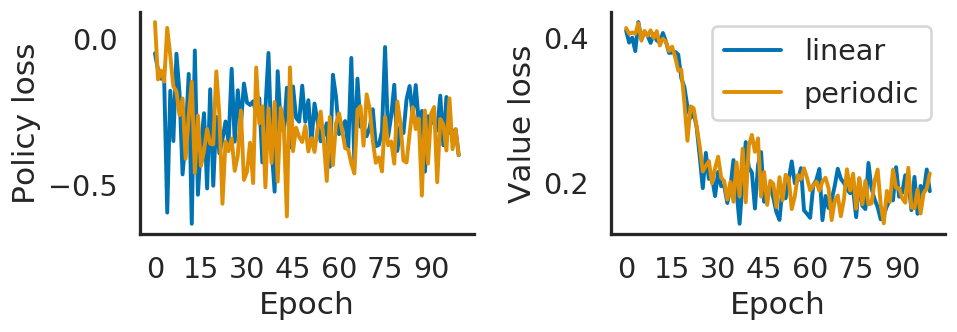

In [13]:
'''loss functions'''

f, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=125)
axes[0].plot(log_loss_policy.mean(2))
axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[0].set_ylabel('Policy loss')
axes[0].set_xlabel('Epoch')

axes[1].plot(log_loss_value.mean(2))
axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[1].set_ylabel('Value loss')
axes[1].set_xlabel('Epoch')

plt.legend(CUES)
sns.despine()
f.tight_layout()

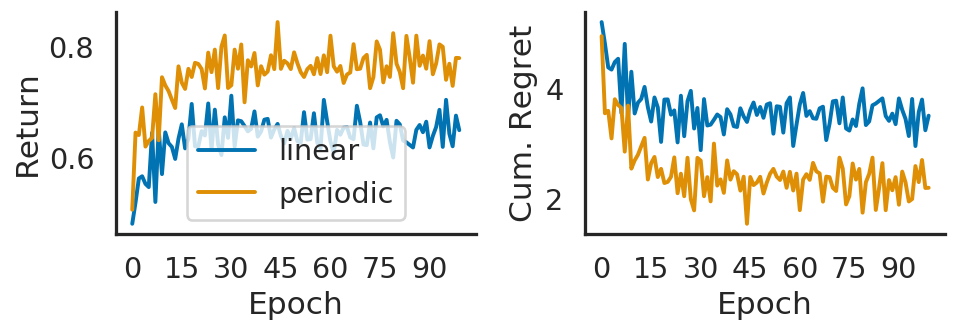

In [14]:
'''learning curves'''

f, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=125)
axes[0].plot(log_return.mean(2))
axes[0].set_ylabel('Return')
axes[0].set_xlabel('Epoch')
axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))
# axes[0].plot(np.repeat(log_Y[:, 0, :, 7].mean(1).mean(),n_epochs), '_k')

# axes[1].plot(log_regret.mean(3).mean(2)) # mean regreat across trials and rounds
axes[1].plot(log_regret.cumsum(3).max(3).mean(2))
axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[1].set_ylabel('Cum. Regret')
axes[1].set_xlabel('Epoch')

axes[0].legend(CUES)
sns.despine()
f.tight_layout()

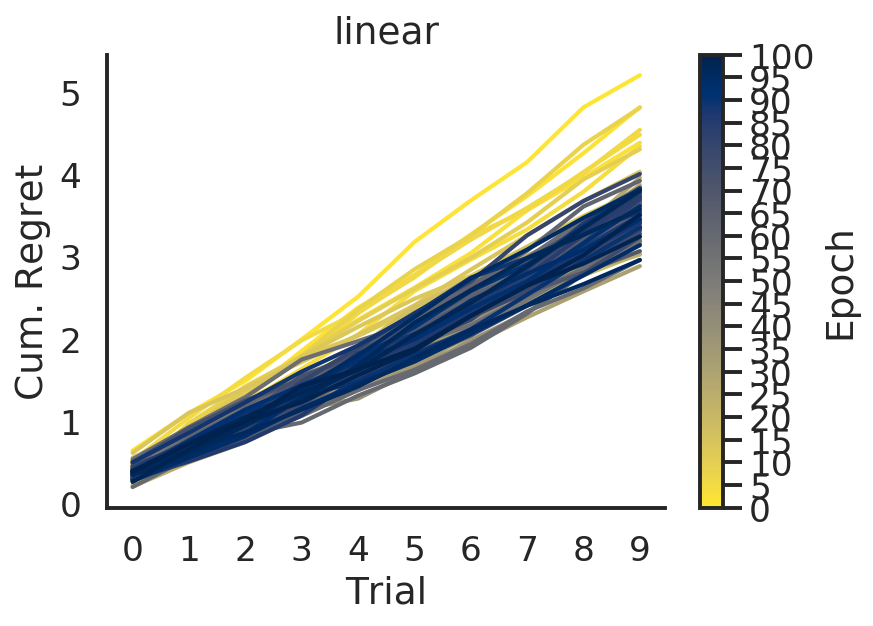

In [15]:
''' cumulative regret across trials per epoch (averaged across episodes/rounds)'''

cue = 'linear'

cue_id = None
for idx, key in enumerate(CUES.keys()):
    if key == cue:
        cue_id = idx        
assert(cue_id is not None)

# set up the color scheme
c = np.arange(n_epochs+1)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.cividis_r)
cmap.set_array([])

# configure figure
f, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=150)
cum_regret = log_regret.cumsum(3)
for ep in range(n_epochs):
    ax.plot(cum_regret[ep,cue_id,:,:].T.mean(1), linewidth=2, c=cmap.to_rgba(ep + 1))
            
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set(xlabel='Trial',
       ylabel='Cum. Regret',
       title=cue)
cbar = plt.colorbar(cmap, ticks=np.arange(n_epochs+1, step=5), ax=ax)
cbar.set_label('Epoch', rotation=90)
sns.despine()

for aa in ax.xaxis.get_major_ticks():
    aa.set_visible(True)

plt.show()

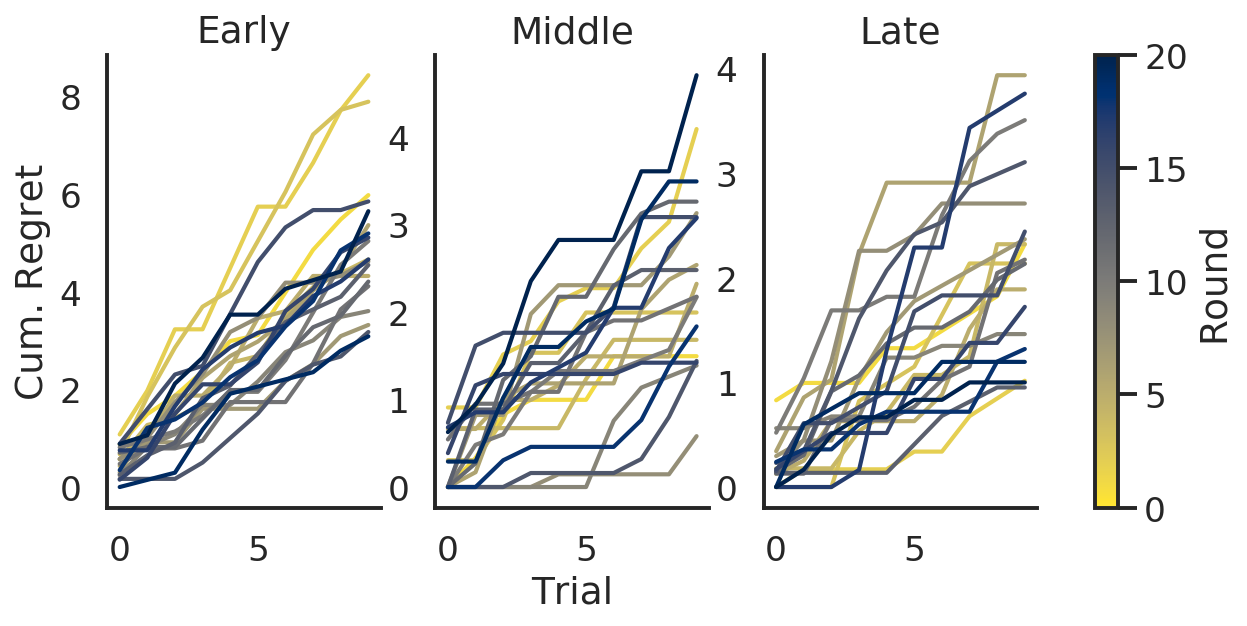

In [36]:
''' cumulative regret across trials across rounds in early, middle, last epoch'''

cue = 'linear'
early_epoch = 0
middle_epoch = np.int(n_epochs/2)
late_epoch = (n_epochs - 1)

cue_id = None
for idx, key in enumerate(CUES.keys()):
    if key == cue:
        cue_id = idx
assert(cue_id is not None)

# set up the color scheme
c = np.arange(n_rounds+1)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.cividis_r)
cmap.set_array([])

# configure figure
f, ax = plt.subplots(1, 3, figsize=(10, 4), dpi=150)
cum_regret = log_regret.cumsum(3)
for rnd in range(n_rounds):
    ax[0].plot(cum_regret[early_epoch,cue_id, rnd,:].T, linewidth=2, c=cmap.to_rgba(rnd + 1))
    ax[1].plot(cum_regret[middle_epoch,cue_id, rnd,:].T, linewidth=2, c=cmap.to_rgba(rnd + 1))
    ax[2].plot(cum_regret[late_epoch,cue_id, rnd,:].T, linewidth=2, c=cmap.to_rgba(rnd + 1))
    
# ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax[0].set(ylabel='Cum. Regret', title='Early')
ax[1].set(xlabel='Trial', title='Middle')
ax[2].set(title='Late')

#plt.suptitle('test')
cbar = plt.colorbar(cmap, ticks=np.arange(n_epochs+1, step=5), ax=ax)
cbar.set_label('Round', rotation=90)
sns.despine()
plt.show()


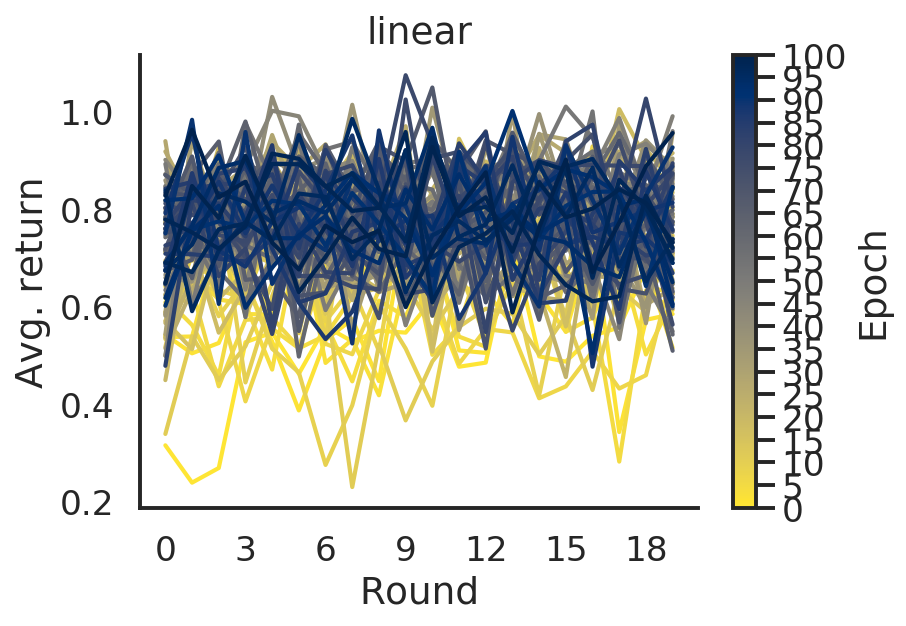

In [46]:
''' average rewards across rounds across epochs'''

cue = 'linear'

cue_id = None
for idx, key in enumerate(CUES.keys()):
    if key == cue:
        cue_id = idx
assert(cue_id is not None)

# set up the color scheme
c = np.arange(n_epochs+1)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.cividis_r)
cmap.set_array([])

# configure figure
f, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=150)
for ep in range(n_epochs):
    ax.plot(log_return[ep, cue_id], linewidth=2, c=cmap.to_rgba(ep + 1))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set(xlabel='Round',
       ylabel='Avg. return',
      title=cue)
cbar = plt.colorbar(cmap, ticks=np.arange(n_epochs+1, step=5), ax=ax)
cbar.set_label('Epoch', rotation=90)
sns.despine()
plt.show()

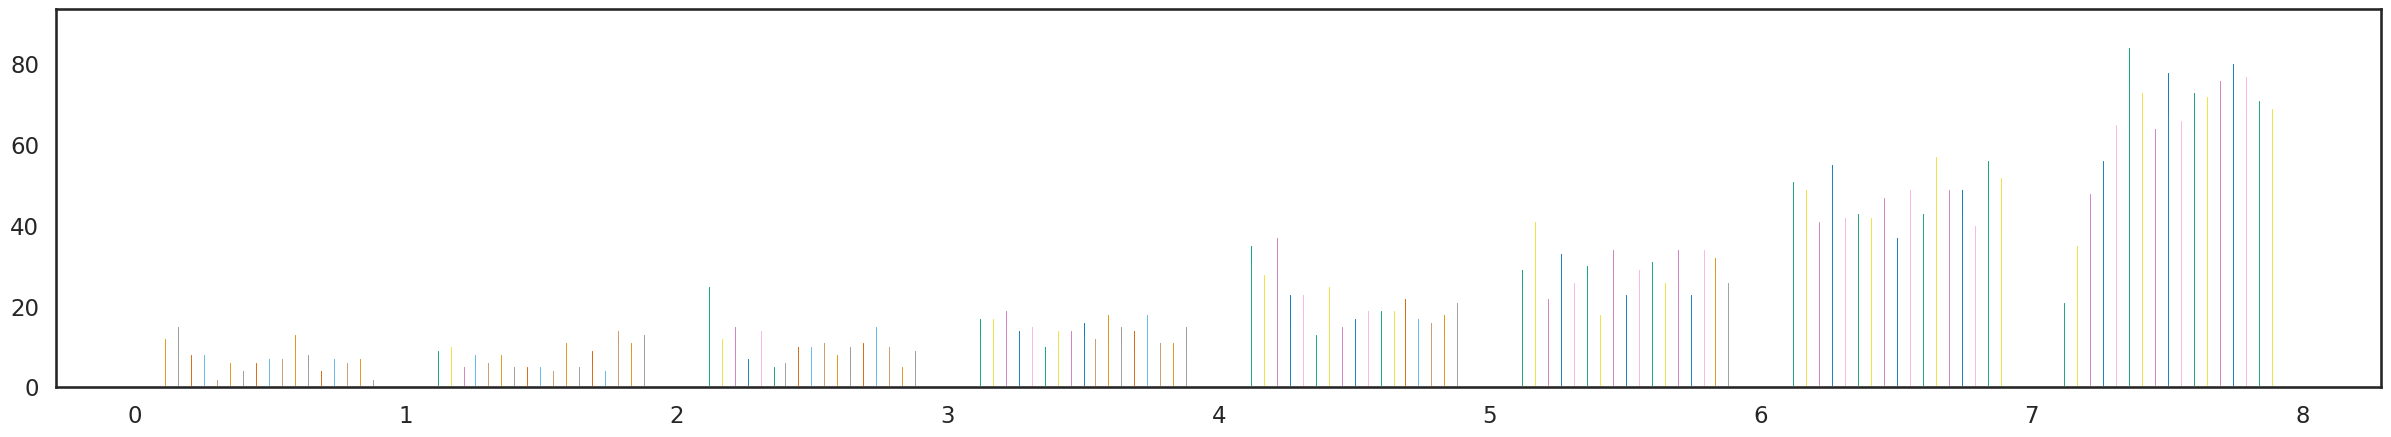

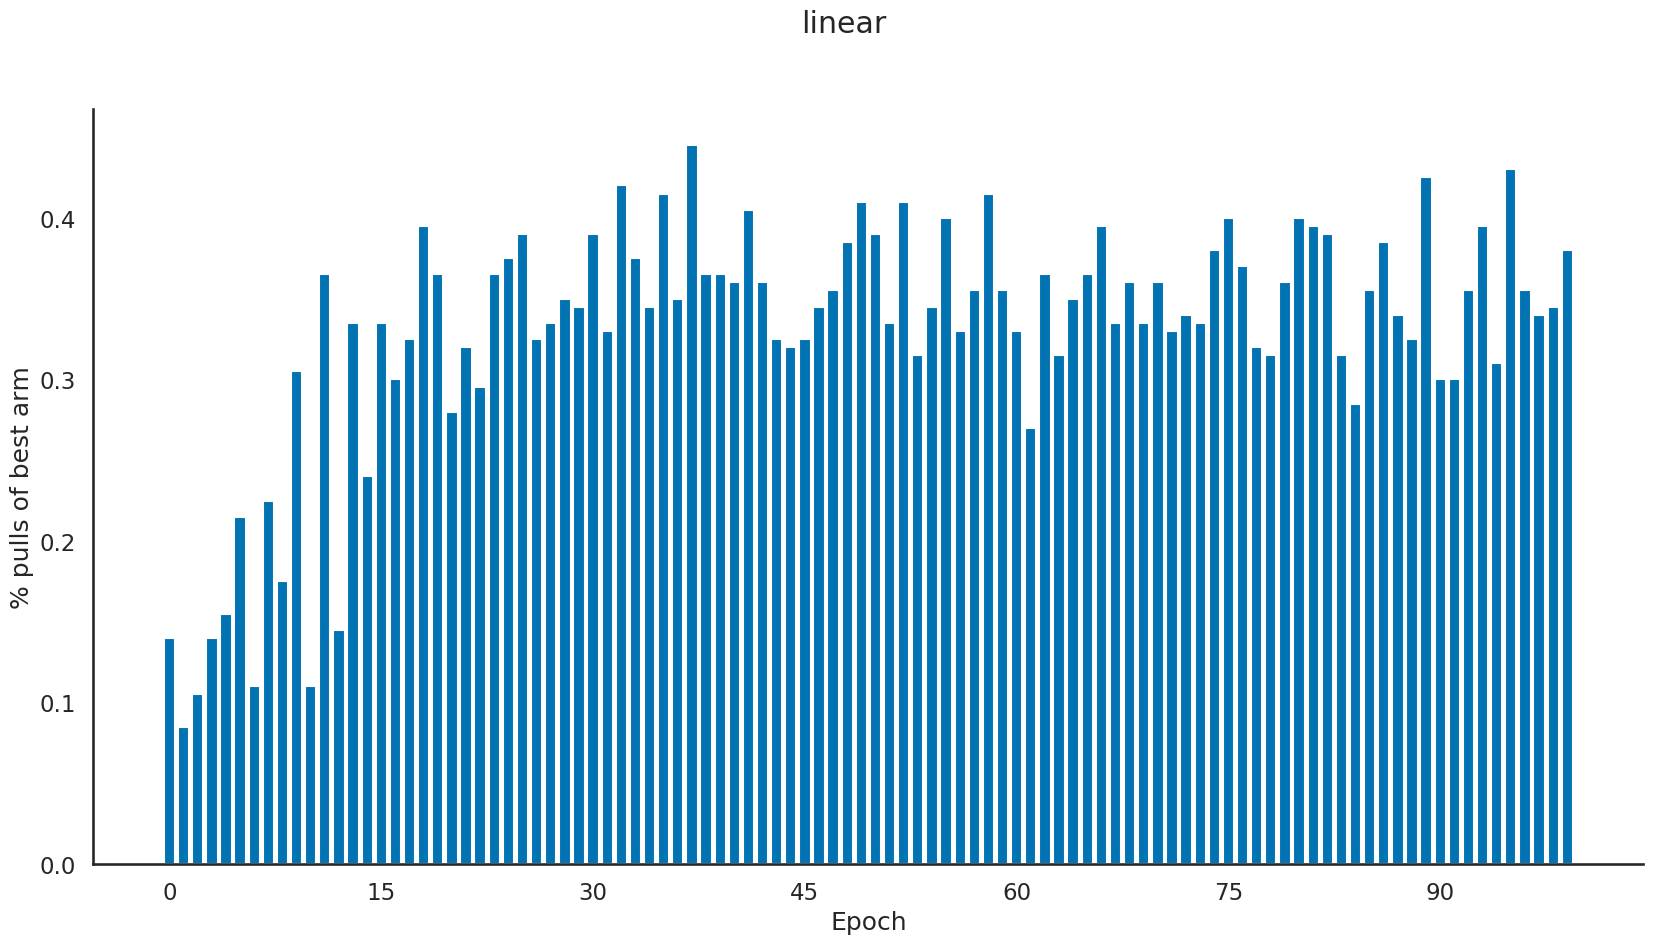

In [23]:
''' action distribution across epochs'''

cue = 'linear'

cue_id = None
for idx, key in enumerate(CUES.keys()):
    if key == cue:
        cue_id = idx
f, ax = plt.subplots(1, 1, figsize=(30, 5), dpi=100)
bins = np.linspace(start_arm, end_arm+1, n_arms+1)
pulls_per_arm = plt.hist(log_Y_hat[:, cue_id, :, :].reshape(n_epochs, n_rounds*n_trials).T, bins=bins)
#ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
#ax[0].set(xlabel='Arm', ylabel='No. of pulls per arm')
#ax[0].set_xlim([start_arm, end_arm+1])

f, ax = plt.subplots(1, 1, figsize=(20, 10), dpi=100)
ax.bar(range(n_epochs), np.vstack(pulls_per_arm[0])[:,aoi[cue]]/(n_rounds*n_trials))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set(ylabel='% pulls of best arm',
       xlabel='Epoch')
f.suptitle(cue)
sns.despine()
plt.savefig(cue)

In [16]:
CUES_EVAL =  {'linear': torch.tensor([1.0, 0.0]), 'periodic': torch.tensor([0.0, 1.0]), 'linperiodic': torch.tensor([1.0, 1.0])} 
task = MultiArmedBandit(cues=CUES_EVAL, start_arm=start_arm, end_arm=end_arm, ctx_dim=ctx_dim, num_rounds=n_rounds, normalize=normalize_rewards)

In [22]:
''' model evaluation for different cues'''

cue = 'linperiodic'
n_runs = 100

X, Y = task.sample(end_rnd=1, cue=cue)

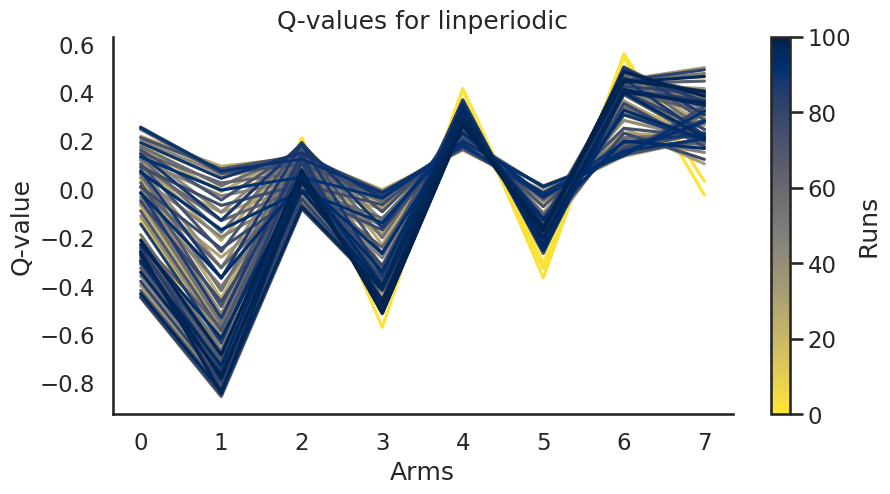

In [23]:
# params
#CUES_EVAL = CUES  # {'periodic': torch.tensor([1., 0.]), 
                  #  'linear':   torch.tensor([0., 1.]), 
                  #  'linperiodic': torch.tensor([1.0, 1.0])} 
n_cues = len(CUES_EVAL)
 
# set up the color scheme
c = np.arange(n_runs+1)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.cividis_r)
cmap.set_array([])

# run model for n_runs
agent.eval()
agent.turn_off_encoding()

# set init states
h_t, c_t = agent.get_init_states()
h_t, c_t = torch.zeros_like(h_t), torch.zeros_like(c_t) 
a_t = torch.randint(high=dim_output,size=(1,))
r_t = Y[0][a_t] 
actions, dist, values, temps = [], [], [], []
f, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=100)

# run model
for t in range(n_runs):
    h_t1 = h_t
    c_t1 = c_t
    x_t = CUES_EVAL[cue]  
    if agent.inputs == 'context_action_reward':
        one_hot_a_t = one_hot_embedding(a_t, n_arms)
        x_t = torch.cat((x_t, one_hot_a_t.reshape(-1).type(torch.FloatTensor), r_t.reshape(-1).type(torch.FloatTensor)), dim=0)
    output_t, c = agent(x_t, h_t, c_t) 
    a_t, prob_a_t, v_t, h_t, c_t = output_t
    f_t, i_t, o_t, rg_t, m_t, q_t, pa_t = c
    a_t = torch.argmax(q_t)
    
    # bootstrap reward from q-values
    r_t = q_t[0][a_t]
    
    ax.plot(q_t.detach().numpy().T, c=cmap.to_rgba(t + 1))
    dist.append(torch.sum(F.pairwise_distance(h_t1, h_t, p=2)))
    actions.append(a_t) 
    temps.append(rg_t) 
    values.append(q_t[0][aoi[cue]]) 
    
# format figure
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set(xlabel='Arms',
       ylabel='Q-value',
      title= 'Q-values for {}'.format(cue))
cbar = plt.colorbar(cmap, ticks=np.arange(n_runs+1, step=n_runs/5), ax=ax)
cbar.set_label('Runs', rotation=90)
sns.despine()
plt.show()

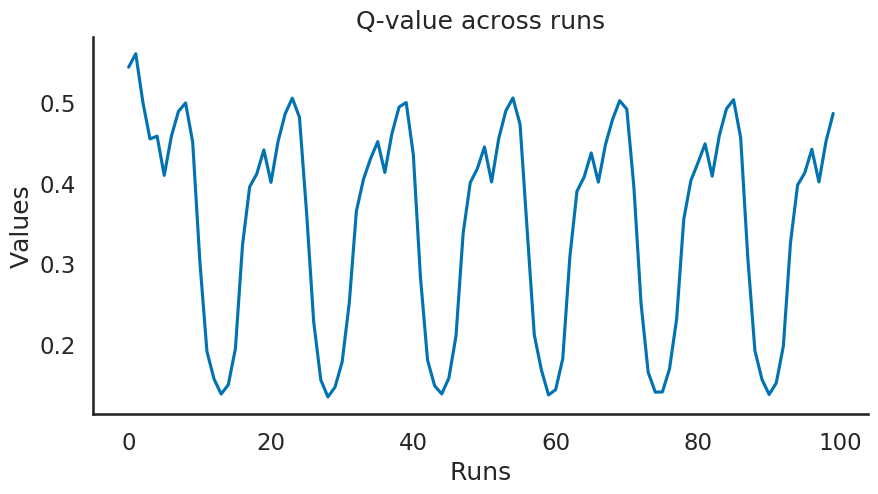

In [24]:
f, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=100)
ax.plot(values)
ax.set(xlabel='Runs',
       ylabel='Values',
      title='Q-value across runs')
sns.despine()
plt.show()

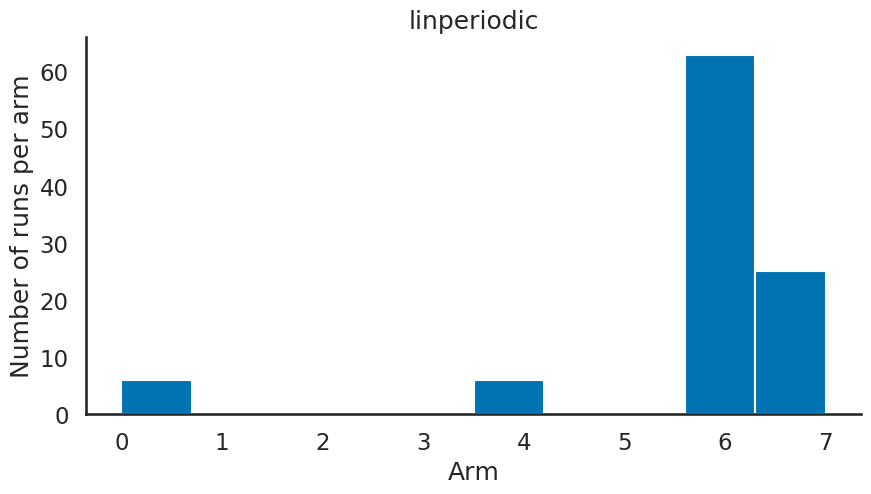

In [25]:
f, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=100)
_ = ax.hist(actions)
ax.set(xlabel='Arm',
       ylabel='Number of runs per arm', title = cue)
sns.despine()
plt.show()